In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from utils import show_images, mask_img

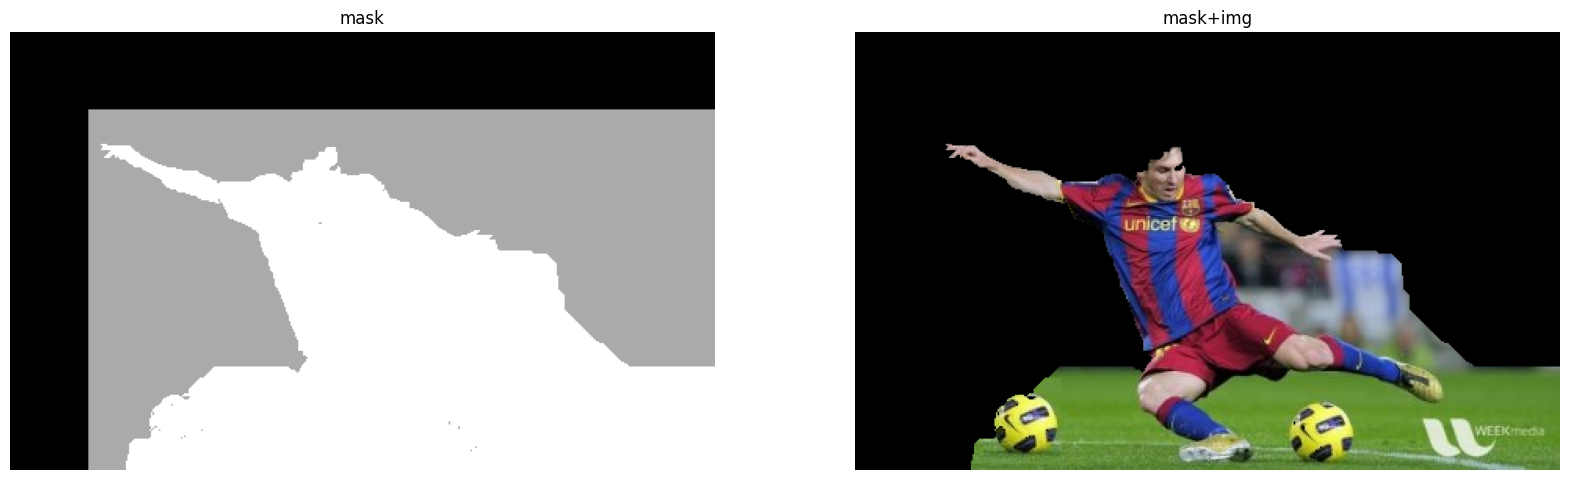

In [2]:
'''
grabCut 初次使用
'''
src = cv2.imread('./image/messi5.jpg', -1)

# mask - 这是一个掩码图像，我们指定哪些区域是背景，前景或可能的背景/前景等。取值为 [0, 4)，具体可搜索 GrabCutClasses
# rect - 矩形的坐标，包括格式为（x，y，w，h）的前景对象
# bdgModel, fgdModel - 内部算法使用的数组。通常只需创建两个大小为(1, 65)的 np.float64 类型零数组。
mask = np.ones(src.shape[0:2], np.uint8) * 3
rect = (50, 50, 450, 290)
bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

mask, bgdModel, fgdModel = cv2.grabCut(src, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# mask: 0 肯定背景，1 肯定前景，2 可能背景，3 可能前景
show_images([
    ('mask', mask),                               # 掩码
    ('mask+img', mask_img(src, (mask==1)|(mask==3))), # 掩码后的图片
])

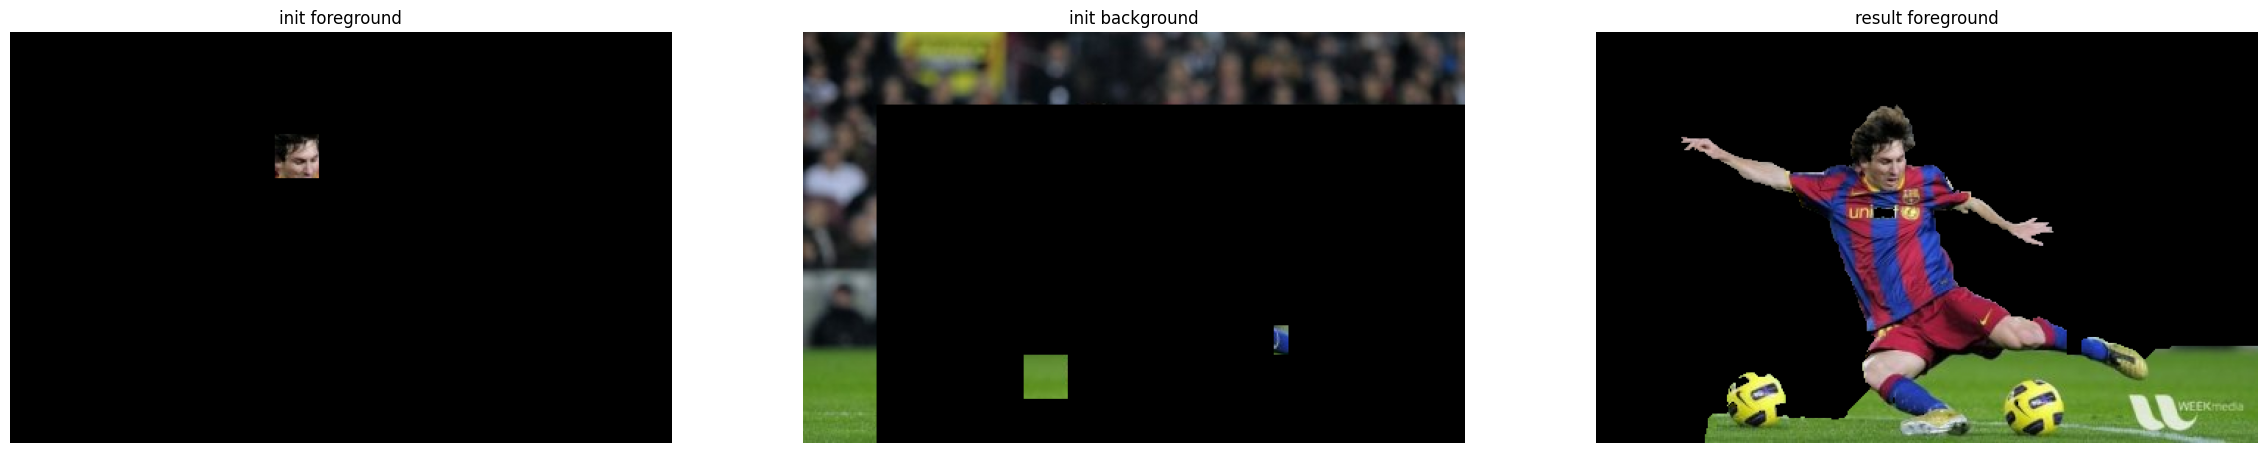

In [3]:
'''
添加自定义的前景背景，加强 grabCut 准确度
'''
results = []

# mask: 0 肯定背景，1 肯定前景，2 可能背景，3 可能前景
mask[70:100, 180:210] = 1
mask[220:250, 150:180] = 0
mask[200:220, 320:330] = 0

# 展示一下 mask 的情况
results.append( ('init foreground', mask_img(src, (mask==1))) )
results.append( ('init background', mask_img(src, (mask==0))) )

# 注意这里从 WITH_RECT 变为 WITH_MASK 
mask, bgdModel, fgdModel = cv2.grabCut(src, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)
results.append( ('result foreground', mask_img(src, (mask==1)|(mask==3))) )

show_images(results)

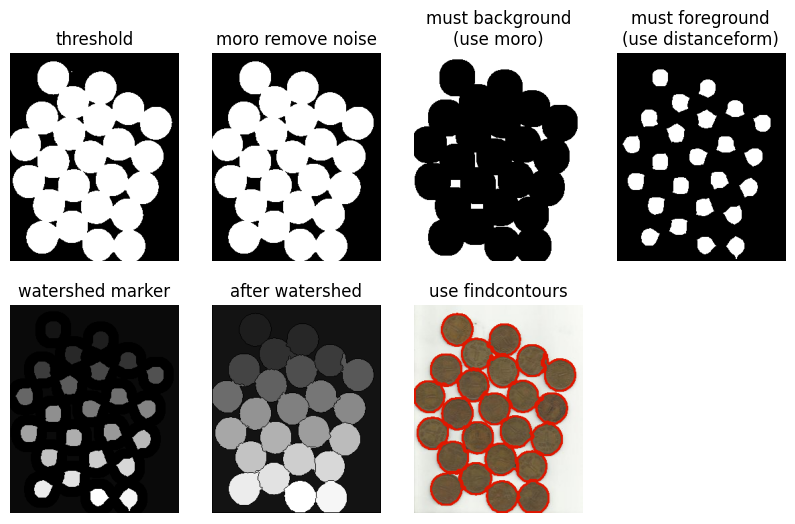

In [4]:
results = []

src = cv2.imread('./image/coins.jpg', -1)
src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

# 阈值 + 形态学处理去除噪声
ret, bin_img = cv2.threshold(src_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
results.append( ['threshold', np.copy(bin_img)] )

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)
results.append( ['moro remove noise', np.copy(bin_img)] )

# 利用形态学找一些一定是背景的部分
sure_bg = 255 - cv2.dilate(bin_img, kernel, iterations=3)
results.append( ['must background\n(use moro)', sure_bg] )

# 利用 Distance Transform 找一些肯定前景的部分
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 3)
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)  
results.append( ['must foreground\n(use distanceform)', sure_fg] )

# 预处理 watershed 的 marker：编号各个闭合区域，将不确定区域的编号变为 0
ret, markers = cv2.connectedComponents(sure_fg)
markers += 1
markers[np.bitwise_and(sure_bg!=255, sure_fg!=255)] = 0
results.append( ['watershed marker', np.copy(markers)] )

# 使用 watershed，直接传入彩色图
markers = cv2.watershed(src, markers)
results.append( ['after watershed', np.copy(markers)])

# 后续就可以使用 contours 获取轮廓了
labels = np.unique(markers)
coins = []
for label in labels[2:]:  
    target = np.where(markers == label, 255, 0).astype(np.uint8)
    contours, hierarchy = cv2.findContours(
        target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    # 轮廓可能不是很圆，也可以用 minEnclosingCircle 画个圆
    # ((x, y), r) = cv2.minEnclosingCircle(contours[0])
    # cv2.circle(src, (int(x), int(y)), int(r), (0, 255, 0), 2)
    coins.append(contours[0])
img = cv2.drawContours(src, coins, -1, color=(0, 23, 223), thickness=2)
results.append( ['use findcontours', img] )

show_images(results)